In [1]:
!pip install pandas
!pip install matplotlib

/tmp/ipykernel_2017/970244994.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_responses['endpoint_combined'] = df_responses['endpoint'].apply(lambda x: x.split('?')[0])


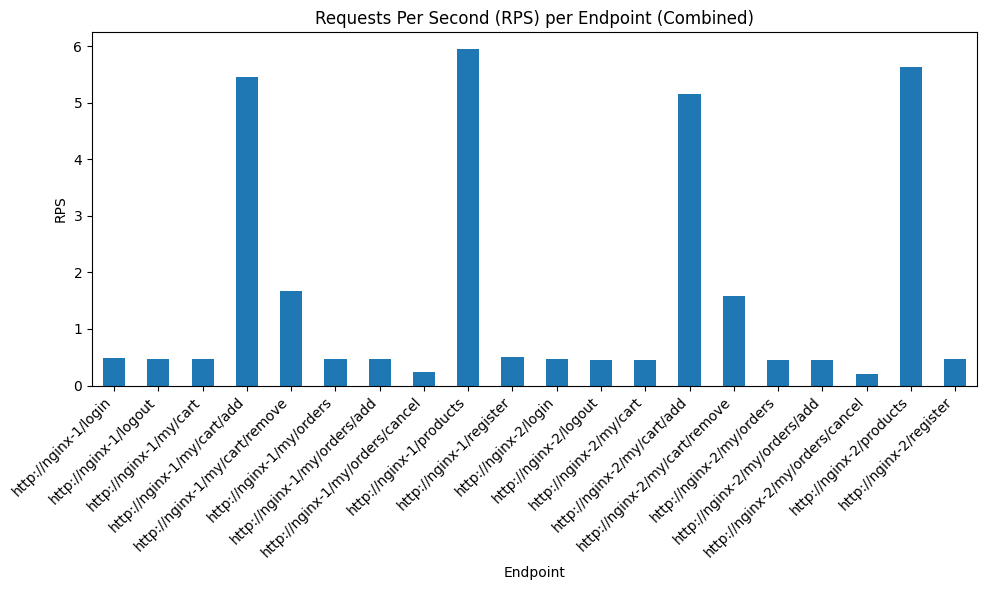

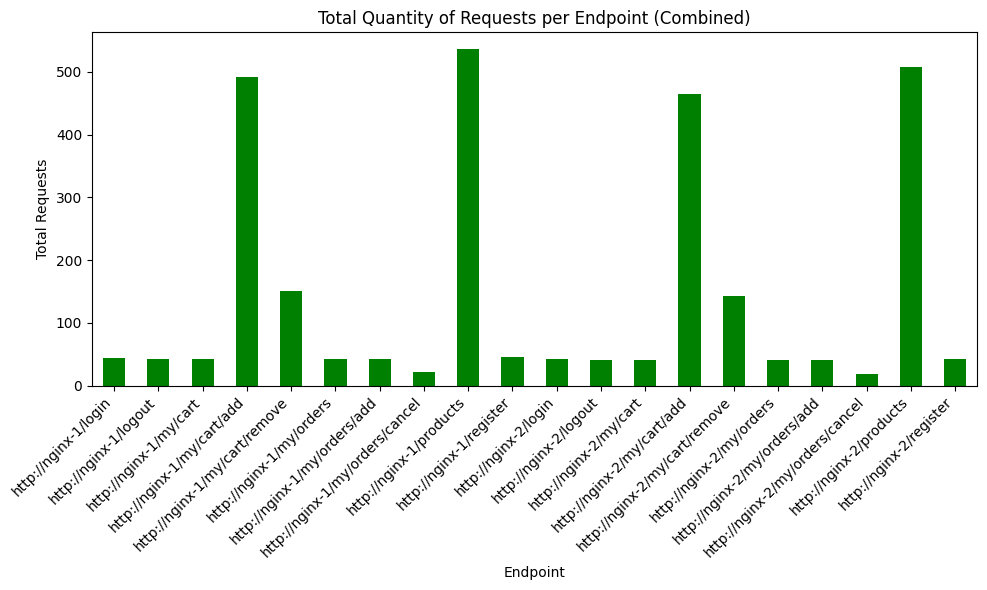

In [2]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt

df = pd.DataFrame()

for file in pathlib.Path("logs").iterdir():
    df = pd.concat([df, pd.read_csv(file, names=['timestamp', 'type', 'endpoint', 'method', 'query', 'status', 'duration', 'operation'], parse_dates=['timestamp'])])

df['duration'] = pd.to_numeric(df['duration'], errors='coerce') 
df_responses = df[df['type'] == 'response'] 

df_responses['endpoint_combined'] = df_responses['endpoint'].apply(lambda x: x.split('?')[0])

total_time = (df_responses['timestamp'].max() - df_responses['timestamp'].min()).total_seconds()
rps_combined = df_responses.groupby('endpoint_combined')['timestamp'].count() / total_time
total_requests_per_combined_endpoint = df_responses.groupby('endpoint_combined')['timestamp'].count()

plt.figure(figsize=(10, 6))
rps_combined.plot(kind='bar')
plt.title('Requests Per Second (RPS) per Endpoint (Combined)')
plt.xlabel('Endpoint')
plt.ylabel('RPS')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
total_requests_per_combined_endpoint.plot(kind='bar', color='green')
plt.title('Total Quantity of Requests per Endpoint (Combined)')
plt.xlabel('Endpoint')
plt.ylabel('Total Requests')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
metrics_summary = pd.DataFrame({
    'RPS': rps_combined,
    'Total Requests': total_requests_per_combined_endpoint
}).reset_index()

print("Metrics Summary:")
metrics_summary

Metrics Summary:


,endpoint_combined,RPS,Total Requests
0,http://nginx-1/login,0.488185,44
1,http://nginx-1/logout,0.477089,43
2,http://nginx-1/my/cart,0.477089,43
3,http://nginx-1/my/cart/add,5.458791,492
4,http://nginx-1/my/cart/remove,1.675361,151
5,http://nginx-1/my/orders,0.477089,43
6,http://nginx-1/my/orders/add,0.477089,43
7,http://nginx-1/my/orders/cancel,0.232997,21
8,http://nginx-1/products,5.946975,536
9,http://nginx-1/register,0.510375,46
